# Final Project - Reinforcements Learning - Ex1

---

<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

Full Notebook:
### https://colab.research.google.com/drive/1umfxWIoivhACC9YcWRZIxINsZch9JEaC?usp=sharing

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install stable-baselines3[extra]
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip
!git clone https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission.git


# Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn.functional as F
from itertools import count
from stable_baselines3 import PPO
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [3]:
assert torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [5]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function - given an environment it will return the indexes position and boxes locations

In [6]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [7]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

#Utils

In [8]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1

h, w, c = sok.observation_space.shape

# Capture the initial configuration for fixed environment (Ex1) and reset env method to use after every episode
initial_room_state = sok.room_state.copy()
initial_room_fixed = sok.room_fixed.copy()
initial_player_position = sok.player_position.copy()
initial_box_position = find_box_location(sok)


def reset_to_initial(env, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position):
    env.room_state = initial_room_state.copy()
    env.room_fixed = initial_room_fixed.copy()
    env.player_position = initial_player_position.copy()

    env.room_state[env.room_state == 4] = 2
    env.room_state[initial_box_position] = 4

    return env.render(mode='rgb_array')


def save_checkpoint(filename, policy_model):
    checkpoint = {
        'policy_model_state_dict': policy_model.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(filename, policy_model, target_model):
    checkpoint = torch.load(filename)
    policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
    target_model.load_state_dict(policy_model.state_dict())
    target_model.eval()


def plot_model_performance(mean_rewards, mean_lengths):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(mean_rewards)
  plt.title('Mean Episodic Reward')
  plt.xlabel('Episode')
  plt.ylabel('Mean Reward')

  plt.subplot(1, 2, 2)
  plt.plot(mean_lengths)
  plt.title('Mean Episodic Length')
  plt.xlabel('Episode')
  plt.ylabel('Mean Length')

  plt.show()

#DQN Model

In [9]:
# Calculate the dimensions after passing through all the convolutional layers
convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
linear_input_size = convw * convh * 32  # 32 is the output channel size of the last conv layer

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#Experience Replay

In [10]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Training

In [11]:
# Hyperparameters
BATCH_SIZE = 256
GAMMA = 0.95       #was 0.999
EPS_START = 1.0    # was 0.9
EPS_END = 0.1      # was 0.05
EPS_DECAY = 20000  #was 10,000
TARGET_UPDATE = 5

# Bad way to update epsilon
steps_done = 0

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create the DQN and target network
n_actions = sok.action_space.n
policy_net = DQN(h, w, n_actions).to(device)
target_net = DQN(h, w, n_actions).to(device)

# Optimizer and Memory
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Experience(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [13]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [16]:
def train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=100):

  total_rewards = 0
  total_lengths = 0
  mean_rewards = []
  mean_lengths = []

  for i_episode in tqdm(range(num_episodes)):

    episode_reward = 0.0

    state_array = reset_to_initial(sok, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position)
    state = torch.tensor(state_array.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)

    previous_player_position = None

    # Save once every 10 episodes
    if (i_episode + 1) % 10 == 0:
      save_checkpoint("DQN-checkpoint-v1-ep" + str(i_episode), policy_net)

    for t in range(max_steps_per_episode):
      action = select_action(state)
      next_state, reward, done, info = sok.step(action.item())

      # Check if the episode ended and was successful
      if done and t < 250:
        reward += 10

      # Check if the box has not moved and penalize
      if not info['action.moved_box']:
          reward -= 0.1
      else:
          reward += 0.1

      current_player_position = sok.player_position
      if np.array_equal(previous_player_position, current_player_position):
        reward -= 0.1


      previous_player_position = current_player_position
      episode_reward += reward

      next_state = torch.tensor(next_state.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      reward = torch.tensor([reward], device=device)
      memory.push(state, action, next_state, reward, done)
      state = next_state

      optimize_model()
      if done:
          break

    total_rewards += episode_reward
    total_lengths += t + 1

    mean_episodic_reward = total_rewards / (i_episode + 1)
    mean_episodic_length = total_lengths / (i_episode + 1)

    mean_rewards.append(mean_episodic_reward)
    mean_lengths.append(mean_episodic_length)

    print()
    print("=" * 20 + "Training Progress " + "Episode " + str(i_episode + 1) + "=" * 20)
    print("Mean Episode Reward: ", mean_episodic_reward)
    print("Mean Episode Length: ", mean_episodic_length)
    print(f"Current Episode Reward: {episode_reward}")
    print(f"Current Episode Length: {t + 1}")

    print()



    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

  return mean_rewards, mean_lengths

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train Model

In [17]:
mean_rewards, mean_lengths = train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=100)

  1%|          | 1/100 [00:17<28:42, 17.40s/it]


====================Training Progress Episode 1====================
Mean Episode Reward:  -116.20000000000037
Mean Episode Length:  499.0
Current Episode Reward: -116.20000000000037
Current Episode Length: 499



  2%|▏         | 2/100 [00:34<28:19, 17.34s/it]


====================Training Progress Episode 2====================
Mean Episode Reward:  -115.35000000000026
Mean Episode Length:  499.5
Current Episode Reward: -114.50000000000016
Current Episode Length: 500



  3%|▎         | 3/100 [00:52<28:23, 17.56s/it]


====================Training Progress Episode 3====================
Mean Episode Reward:  -115.63333333333355
Mean Episode Length:  499.6666666666667
Current Episode Reward: -116.20000000000014
Current Episode Length: 500



  4%|▍         | 4/100 [01:10<28:31, 17.83s/it]


====================Training Progress Episode 4====================
Mean Episode Reward:  -116.50000000000013
Mean Episode Length:  499.75
Current Episode Reward: -119.09999999999987
Current Episode Length: 500



  5%|▌         | 5/100 [01:21<24:07, 15.24s/it]


====================Training Progress Episode 5====================
Mean Episode Reward:  -103.9800000000001
Mean Episode Length:  458.8
Current Episode Reward: -53.90000000000009
Current Episode Length: 295



  6%|▌         | 6/100 [01:40<25:56, 16.56s/it]


====================Training Progress Episode 6====================
Mean Episode Reward:  -105.55000000000013
Mean Episode Length:  465.6666666666667
Current Episode Reward: -113.40000000000025
Current Episode Length: 500



  7%|▋         | 7/100 [01:51<22:58, 14.82s/it]


====================Training Progress Episode 7====================
Mean Episode Reward:  -99.00000000000013
Mean Episode Length:  444.57142857142856
Current Episode Reward: -59.70000000000012
Current Episode Length: 318



  8%|▊         | 8/100 [02:09<24:08, 15.75s/it]


====================Training Progress Episode 8====================
Mean Episode Reward:  -100.71250000000015
Mean Episode Length:  451.5
Current Episode Reward: -112.70000000000022
Current Episode Length: 500



  9%|▉         | 9/100 [02:13<18:15, 12.04s/it]


====================Training Progress Episode 9====================
Mean Episode Reward:  -89.90000000000013
Mean Episode Length:  413.55555555555554
Current Episode Reward: -3.399999999999995
Current Episode Length: 110



 10%|█         | 10/100 [02:24<17:24, 11.61s/it]


====================Training Progress Episode 10====================
Mean Episode Reward:  -86.26000000000013
Mean Episode Length:  401.8
Current Episode Reward: -53.50000000000013
Current Episode Length: 296



 11%|█         | 11/100 [02:33<16:04, 10.84s/it]


====================Training Progress Episode 11====================
Mean Episode Reward:  -82.6818181818183
Mean Episode Length:  388.45454545454544
Current Episode Reward: -46.90000000000012
Current Episode Length: 255



 12%|█▏        | 12/100 [02:39<13:42,  9.34s/it]


====================Training Progress Episode 12====================
Mean Episode Reward:  -77.22500000000012
Mean Episode Length:  369.9166666666667
Current Episode Reward: -17.20000000000004
Current Episode Length: 166



 13%|█▎        | 13/100 [02:56<17:17, 11.92s/it]


====================Training Progress Episode 13====================
Mean Episode Reward:  -79.7615384615386
Mean Episode Length:  379.9230769230769
Current Episode Reward: -110.20000000000041
Current Episode Length: 500



 14%|█▍        | 14/100 [03:14<19:39, 13.71s/it]


====================Training Progress Episode 14====================
Mean Episode Reward:  -82.09285714285731
Mean Episode Length:  388.5
Current Episode Reward: -112.40000000000045
Current Episode Length: 500



 15%|█▌        | 15/100 [03:28<19:36, 13.84s/it]


====================Training Progress Episode 15====================
Mean Episode Reward:  -81.61333333333351
Mean Episode Length:  388.8666666666667
Current Episode Reward: -74.90000000000026
Current Episode Length: 394



 16%|█▌        | 16/100 [03:46<21:02, 15.03s/it]


====================Training Progress Episode 16====================
Mean Episode Reward:  -83.3500000000002
Mean Episode Length:  395.8125
Current Episode Reward: -109.40000000000028
Current Episode Length: 500



 17%|█▋        | 17/100 [04:04<22:04, 15.96s/it]


====================Training Progress Episode 17====================
Mean Episode Reward:  -84.8294117647061
Mean Episode Length:  401.94117647058823
Current Episode Reward: -108.50000000000055
Current Episode Length: 500



 18%|█▊        | 18/100 [04:06<16:07, 11.80s/it]


====================Training Progress Episode 18====================
Mean Episode Reward:  -79.63333333333352
Mean Episode Length:  382.94444444444446
Current Episode Reward: 8.700000000000001
Current Episode Length: 60



 19%|█▉        | 19/100 [04:24<18:22, 13.61s/it]


====================Training Progress Episode 19====================
Mean Episode Reward:  -81.2263157894739
Mean Episode Length:  389.10526315789474
Current Episode Reward: -109.9000000000005
Current Episode Length: 500



 20%|██        | 20/100 [04:36<17:35, 13.20s/it]


====================Training Progress Episode 20====================
Mean Episode Reward:  -80.33000000000021
Mean Episode Length:  386.85
Current Episode Reward: -63.30000000000017
Current Episode Length: 344



 21%|██        | 21/100 [04:39<13:03,  9.91s/it]


====================Training Progress Episode 21====================
Mean Episode Reward:  -76.16666666666687
Mean Episode Length:  371.3809523809524
Current Episode Reward: 7.10000000000001
Current Episode Length: 62



 22%|██▏       | 22/100 [04:53<14:30, 11.17s/it]


====================Training Progress Episode 22====================
Mean Episode Reward:  -76.14545454545475
Mean Episode Length:  372.45454545454544
Current Episode Reward: -75.7000000000003
Current Episode Length: 395



 23%|██▎       | 23/100 [05:01<13:00, 10.14s/it]


====================Training Progress Episode 23====================
Mean Episode Reward:  -73.95217391304368
Mean Episode Length:  365.60869565217394
Current Episode Reward: -25.70000000000003
Current Episode Length: 215



 24%|██▍       | 24/100 [05:02<09:37,  7.60s/it]


====================Training Progress Episode 24====================
Mean Episode Reward:  -70.34166666666685
Mean Episode Length:  351.9583333333333
Current Episode Reward: 12.699999999999998
Current Episode Length: 38



 25%|██▌       | 25/100 [05:15<11:29,  9.19s/it]


====================Training Progress Episode 25====================
Mean Episode Reward:  -70.3960000000002
Mean Episode Length:  352.32
Current Episode Reward: -71.70000000000019
Current Episode Length: 361



 26%|██▌       | 26/100 [05:20<09:52,  8.00s/it]


====================Training Progress Episode 26====================
Mean Episode Reward:  -68.13846153846173
Mean Episode Length:  344.4230769230769
Current Episode Reward: -11.699999999999989
Current Episode Length: 147



 27%|██▋       | 27/100 [05:38<13:21, 10.97s/it]


====================Training Progress Episode 27====================
Mean Episode Reward:  -69.67037037037056
Mean Episode Length:  350.18518518518516
Current Episode Reward: -109.5000000000004
Current Episode Length: 500



 28%|██▊       | 28/100 [05:56<15:39, 13.05s/it]


====================Training Progress Episode 28====================
Mean Episode Reward:  -71.2357142857145
Mean Episode Length:  355.5357142857143
Current Episode Reward: -113.50000000000038
Current Episode Length: 500



 29%|██▉       | 29/100 [06:01<12:32, 10.59s/it]


====================Training Progress Episode 29====================
Mean Episode Reward:  -69.0551724137933
Mean Episode Length:  348.0
Current Episode Reward: -7.999999999999982
Current Episode Length: 137



 30%|███       | 30/100 [06:05<10:00,  8.57s/it]


====================Training Progress Episode 30====================
Mean Episode Reward:  -66.8800000000002
Mean Episode Length:  339.96666666666664
Current Episode Reward: -3.7999999999999936
Current Episode Length: 107



 31%|███       | 31/100 [06:11<09:00,  7.84s/it]


====================Training Progress Episode 31====================
Mean Episode Reward:  -65.23548387096793
Mean Episode Length:  334.5483870967742
Current Episode Reward: -15.900000000000006
Current Episode Length: 172



 32%|███▏      | 32/100 [06:17<08:10,  7.22s/it]


====================Training Progress Episode 32====================
Mean Episode Reward:  -63.65312500000018
Mean Episode Length:  329.125
Current Episode Reward: -14.599999999999987
Current Episode Length: 161



 33%|███▎      | 33/100 [06:20<06:48,  6.10s/it]


====================Training Progress Episode 33====================
Mean Episode Reward:  -61.706060606060774
Mean Episode Length:  322.09090909090907
Current Episode Reward: 0.6000000000000334
Current Episode Length: 97



 34%|███▍      | 34/100 [06:23<05:41,  5.17s/it]


====================Training Progress Episode 34====================
Mean Episode Reward:  -59.80882352941193
Mean Episode Length:  315.11764705882354
Current Episode Reward: 2.8000000000000185
Current Episode Length: 85



 35%|███▌      | 35/100 [06:30<06:03,  5.60s/it]


====================Training Progress Episode 35====================
Mean Episode Reward:  -58.73142857142874
Mean Episode Length:  311.37142857142857
Current Episode Reward: -22.10000000000008
Current Episode Length: 184



 36%|███▌      | 36/100 [06:32<04:43,  4.44s/it]


====================Training Progress Episode 36====================
Mean Episode Reward:  -56.80833333333349
Mean Episode Length:  304.05555555555554
Current Episode Reward: 10.500000000000005
Current Episode Length: 48



 37%|███▋      | 37/100 [06:35<04:23,  4.18s/it]


====================Training Progress Episode 37====================
Mean Episode Reward:  -55.31351351351367
Mean Episode Length:  298.56756756756755
Current Episode Reward: -1.4999999999999822
Current Episode Length: 101



 38%|███▊      | 38/100 [06:36<03:16,  3.17s/it]


====================Training Progress Episode 38====================
Mean Episode Reward:  -53.44210526315805
Mean Episode Length:  291.3157894736842
Current Episode Reward: 15.799999999999999
Current Episode Length: 23



 39%|███▉      | 39/100 [06:37<02:41,  2.65s/it]


====================Training Progress Episode 39====================
Mean Episode Reward:  -51.756410256410405
Mean Episode Length:  284.87179487179486
Current Episode Reward: 12.299999999999999
Current Episode Length: 40



 40%|████      | 40/100 [06:40<02:31,  2.53s/it]


====================Training Progress Episode 40====================
Mean Episode Reward:  -50.27500000000015
Mean Episode Length:  279.325
Current Episode Reward: 7.500000000000005
Current Episode Length: 63



 41%|████      | 41/100 [06:42<02:20,  2.38s/it]


====================Training Progress Episode 41====================
Mean Episode Reward:  -48.83170731707331
Mean Episode Length:  273.8780487804878
Current Episode Reward: 8.899999999999997
Current Episode Length: 56



 42%|████▏     | 42/100 [06:44<02:12,  2.28s/it]


====================Training Progress Episode 42====================
Mean Episode Reward:  -47.47142857142871
Mean Episode Length:  268.7142857142857
Current Episode Reward: 8.300000000000004
Current Episode Length: 57



 43%|████▎     | 43/100 [06:45<01:46,  1.88s/it]


====================Training Progress Episode 43====================
Mean Episode Reward:  -46.004651162790836
Mean Episode Length:  263.06976744186045
Current Episode Reward: 15.6
Current Episode Length: 26



 44%|████▍     | 44/100 [06:46<01:36,  1.72s/it]


====================Training Progress Episode 44====================
Mean Episode Reward:  -44.63636363636377
Mean Episode Length:  257.95454545454544
Current Episode Reward: 14.2
Current Episode Length: 38



 45%|████▌     | 45/100 [06:48<01:30,  1.65s/it]


====================Training Progress Episode 45====================
Mean Episode Reward:  -43.37777777777791
Mean Episode Length:  253.15555555555557
Current Episode Reward: 11.999999999999998
Current Episode Length: 42



 46%|████▌     | 46/100 [06:51<01:51,  2.07s/it]


====================Training Progress Episode 46====================
Mean Episode Reward:  -42.37173913043491
Mean Episode Length:  249.52173913043478
Current Episode Reward: 2.9000000000000057
Current Episode Length: 86



 47%|████▋     | 47/100 [06:51<01:30,  1.71s/it]


====================Training Progress Episode 47====================
Mean Episode Reward:  -41.129787234042674
Mean Episode Length:  244.72340425531914
Current Episode Reward: 15.999999999999998
Current Episode Length: 24



 48%|████▊     | 48/100 [06:53<01:22,  1.58s/it]


====================Training Progress Episode 48====================
Mean Episode Reward:  -39.99791666666679
Mean Episode Length:  240.375
Current Episode Reward: 13.199999999999996
Current Episode Length: 36



 49%|████▉     | 49/100 [07:04<03:45,  4.43s/it]


====================Training Progress Episode 49====================
Mean Episode Reward:  -40.300000000000125
Mean Episode Length:  241.77551020408163
Current Episode Reward: -54.80000000000017
Current Episode Length: 309



 50%|█████     | 50/100 [07:05<02:47,  3.35s/it]


====================Training Progress Episode 50====================
Mean Episode Reward:  -39.17200000000012
Mean Episode Length:  237.42
Current Episode Reward: 16.099999999999998
Current Episode Length: 24



 51%|█████     | 51/100 [07:06<02:16,  2.78s/it]


====================Training Progress Episode 51====================
Mean Episode Reward:  -38.16470588235306
Mean Episode Length:  233.54901960784315
Current Episode Reward: 12.199999999999998
Current Episode Length: 40



 52%|█████▏    | 52/100 [07:07<01:51,  2.31s/it]


====================Training Progress Episode 52====================
Mean Episode Reward:  -37.17115384615396
Mean Episode Length:  229.69230769230768
Current Episode Reward: 13.499999999999998
Current Episode Length: 33



 53%|█████▎    | 53/100 [07:11<02:02,  2.61s/it]


====================Training Progress Episode 53====================
Mean Episode Reward:  -36.45471698113219
Mean Episode Length:  227.0943396226415
Current Episode Reward: 0.8000000000000149
Current Episode Length: 92



 54%|█████▍    | 54/100 [07:12<01:40,  2.19s/it]


====================Training Progress Episode 54====================
Mean Episode Reward:  -35.54444444444456
Mean Episode Length:  223.5185185185185
Current Episode Reward: 12.7
Current Episode Length: 34



 55%|█████▌    | 55/100 [07:12<01:16,  1.70s/it]


====================Training Progress Episode 55====================
Mean Episode Reward:  -34.58363636363647
Mean Episode Length:  219.74545454545455
Current Episode Reward: 17.3
Current Episode Length: 16



 56%|█████▌    | 56/100 [07:15<01:26,  1.97s/it]


====================Training Progress Episode 56====================
Mean Episode Reward:  -33.87857142857153
Mean Episode Length:  217.125
Current Episode Reward: 4.900000000000013
Current Episode Length: 73



 57%|█████▋    | 57/100 [07:17<01:25,  1.99s/it]


====================Training Progress Episode 57====================
Mean Episode Reward:  -33.129824561403616
Mean Episode Length:  214.31578947368422
Current Episode Reward: 8.800000000000011
Current Episode Length: 57



 58%|█████▊    | 58/100 [07:18<01:14,  1.77s/it]


====================Training Progress Episode 58====================
Mean Episode Reward:  -32.320689655172515
Mean Episode Length:  211.22413793103448
Current Episode Reward: 13.799999999999997
Current Episode Length: 35



 59%|█████▉    | 59/100 [07:20<01:11,  1.74s/it]


====================Training Progress Episode 59====================
Mean Episode Reward:  -31.579661016949252
Mean Episode Length:  208.40677966101694
Current Episode Reward: 11.4
Current Episode Length: 45



 60%|██████    | 60/100 [07:22<01:09,  1.75s/it]


====================Training Progress Episode 60====================
Mean Episode Reward:  -30.8650000000001
Mean Episode Length:  205.75
Current Episode Reward: 11.299999999999999
Current Episode Length: 49



 61%|██████    | 61/100 [07:23<01:07,  1.74s/it]


====================Training Progress Episode 61====================
Mean Episode Reward:  -30.181967213114852
Mean Episode Length:  203.1639344262295
Current Episode Reward: 10.800000000000004
Current Episode Length: 48



 62%|██████▏   | 62/100 [07:25<01:08,  1.81s/it]


====================Training Progress Episode 62====================
Mean Episode Reward:  -29.561290322580742
Mean Episode Length:  200.79032258064515
Current Episode Reward: 8.300000000000004
Current Episode Length: 56



 63%|██████▎   | 63/100 [07:30<01:32,  2.50s/it]


====================Training Progress Episode 63====================
Mean Episode Reward:  -29.13174603174613
Mean Episode Length:  199.4126984126984
Current Episode Reward: -2.4999999999999645
Current Episode Length: 114



 64%|██████▍   | 64/100 [07:31<01:16,  2.13s/it]


====================Training Progress Episode 64====================
Mean Episode Reward:  -28.453125000000096
Mean Episode Length:  196.828125
Current Episode Reward: 14.299999999999997
Current Episode Length: 34



 65%|██████▌   | 65/100 [07:32<00:59,  1.71s/it]


====================Training Progress Episode 65====================
Mean Episode Reward:  -27.753846153846247
Mean Episode Length:  194.09230769230768
Current Episode Reward: 17.0
Current Episode Length: 19



 66%|██████▌   | 66/100 [07:34<01:04,  1.91s/it]


====================Training Progress Episode 66====================
Mean Episode Reward:  -27.22575757575767
Mean Episode Length:  192.12121212121212
Current Episode Reward: 7.100000000000007
Current Episode Length: 64



 67%|██████▋   | 67/100 [07:35<00:58,  1.76s/it]


====================Training Progress Episode 67====================
Mean Episode Reward:  -26.635820895522482
Mean Episode Length:  189.8507462686567
Current Episode Reward: 12.3
Current Episode Length: 40



 68%|██████▊   | 68/100 [07:36<00:47,  1.50s/it]


====================Training Progress Episode 68====================
Mean Episode Reward:  -26.014705882353034
Mean Episode Length:  187.4264705882353
Current Episode Reward: 15.599999999999998
Current Episode Length: 25



 69%|██████▉   | 69/100 [07:38<00:47,  1.54s/it]


====================Training Progress Episode 69====================
Mean Episode Reward:  -25.46376811594212
Mean Episode Length:  185.3768115942029
Current Episode Reward: 12.0
Current Episode Length: 46



 70%|███████   | 70/100 [07:40<00:49,  1.65s/it]


====================Training Progress Episode 70====================
Mean Episode Reward:  -24.954285714285806
Mean Episode Length:  183.5
Current Episode Reward: 10.200000000000006
Current Episode Length: 54



 71%|███████   | 71/100 [07:40<00:38,  1.34s/it]


====================Training Progress Episode 71====================
Mean Episode Reward:  -24.361971830986004
Mean Episode Length:  181.1549295774648
Current Episode Reward: 17.099999999999998
Current Episode Length: 17



 72%|███████▏  | 72/100 [07:41<00:33,  1.18s/it]


====================Training Progress Episode 72====================
Mean Episode Reward:  -23.78750000000009
Mean Episode Length:  178.95833333333334
Current Episode Reward: 17.0
Current Episode Length: 23



 73%|███████▎  | 73/100 [07:42<00:32,  1.19s/it]


====================Training Progress Episode 73====================
Mean Episode Reward:  -23.269863013698718
Mean Episode Length:  176.97260273972603
Current Episode Reward: 13.999999999999996
Current Episode Length: 34



 74%|███████▍  | 74/100 [07:43<00:26,  1.03s/it]


====================Training Progress Episode 74====================
Mean Episode Reward:  -22.716216216216303
Mean Episode Length:  174.82432432432432
Current Episode Reward: 17.7
Current Episode Length: 18



 75%|███████▌  | 75/100 [07:44<00:22,  1.11it/s]


====================Training Progress Episode 75====================
Mean Episode Reward:  -22.181333333333416
Mean Episode Length:  172.72
Current Episode Reward: 17.4
Current Episode Length: 17



 76%|███████▌  | 76/100 [07:44<00:20,  1.16it/s]


====================Training Progress Episode 76====================
Mean Episode Reward:  -21.663157894736923
Mean Episode Length:  170.72368421052633
Current Episode Reward: 17.2
Current Episode Length: 21



 77%|███████▋  | 77/100 [07:45<00:17,  1.33it/s]


====================Training Progress Episode 77====================
Mean Episode Reward:  -21.146753246753327
Mean Episode Length:  168.67532467532467
Current Episode Reward: 18.1
Current Episode Length: 13



 78%|███████▊  | 78/100 [07:46<00:17,  1.28it/s]


====================Training Progress Episode 78====================
Mean Episode Reward:  -20.673076923077005
Mean Episode Length:  166.80769230769232
Current Episode Reward: 15.8
Current Episode Length: 23



 79%|███████▉  | 79/100 [07:46<00:15,  1.39it/s]


====================Training Progress Episode 79====================
Mean Episode Reward:  -20.18860759493679
Mean Episode Length:  164.8987341772152
Current Episode Reward: 17.599999999999998
Current Episode Length: 16



 80%|████████  | 80/100 [07:47<00:15,  1.30it/s]


====================Training Progress Episode 80====================
Mean Episode Reward:  -19.73875000000008
Mean Episode Length:  163.15
Current Episode Reward: 15.799999999999999
Current Episode Length: 25



 81%|████████  | 81/100 [07:49<00:21,  1.11s/it]


====================Training Progress Episode 81====================
Mean Episode Reward:  -19.369135802469216
Mean Episode Length:  161.79012345679013
Current Episode Reward: 10.2
Current Episode Length: 53



 82%|████████▏ | 82/100 [07:51<00:22,  1.26s/it]


====================Training Progress Episode 82====================
Mean Episode Reward:  -19.000000000000078
Mean Episode Length:  160.3780487804878
Current Episode Reward: 10.900000000000004
Current Episode Length: 46



 83%|████████▎ | 83/100 [07:52<00:19,  1.16s/it]


====================Training Progress Episode 83====================
Mean Episode Reward:  -18.579518072289233
Mean Episode Length:  158.75903614457832
Current Episode Reward: 15.899999999999999
Current Episode Length: 26



 84%|████████▍ | 84/100 [07:53<00:17,  1.12s/it]


====================Training Progress Episode 84====================
Mean Episode Reward:  -18.17976190476198
Mean Episode Length:  157.21428571428572
Current Episode Reward: 14.999999999999996
Current Episode Length: 29



 85%|████████▌ | 85/100 [07:54<00:17,  1.16s/it]


====================Training Progress Episode 85====================
Mean Episode Reward:  -17.81058823529419
Mean Episode Length:  155.7764705882353
Current Episode Reward: 13.2
Current Episode Length: 35



 86%|████████▌ | 86/100 [07:56<00:18,  1.30s/it]


====================Training Progress Episode 86====================
Mean Episode Reward:  -17.46511627906984
Mean Episode Length:  154.5
Current Episode Reward: 11.899999999999997
Current Episode Length: 46



 87%|████████▋ | 87/100 [07:57<00:16,  1.26s/it]


====================Training Progress Episode 87====================
Mean Episode Reward:  -17.102298850574783
Mean Episode Length:  153.09195402298852
Current Episode Reward: 14.099999999999998
Current Episode Length: 32



 88%|████████▊ | 88/100 [07:57<00:13,  1.10s/it]


====================Training Progress Episode 88====================
Mean Episode Reward:  -16.71590909090916
Mean Episode Length:  151.5681818181818
Current Episode Reward: 16.9
Current Episode Length: 19



 89%|████████▉ | 89/100 [07:58<00:11,  1.06s/it]


====================Training Progress Episode 89====================
Mean Episode Reward:  -16.35393258426973
Mean Episode Length:  150.1573033707865
Current Episode Reward: 15.499999999999996
Current Episode Length: 26



 90%|█████████ | 90/100 [08:01<00:14,  1.43s/it]


====================Training Progress Episode 90====================
Mean Episode Reward:  -16.088888888888956
Mean Episode Length:  149.2
Current Episode Reward: 7.500000000000002
Current Episode Length: 64



 91%|█████████ | 91/100 [08:02<00:11,  1.27s/it]


====================Training Progress Episode 91====================
Mean Episode Reward:  -15.738461538461607
Mean Episode Length:  147.83516483516485
Current Episode Reward: 15.799999999999997
Current Episode Length: 25



 92%|█████████▏| 92/100 [08:03<00:10,  1.32s/it]


====================Training Progress Episode 92====================
Mean Episode Reward:  -15.430434782608764
Mean Episode Length:  146.67391304347825
Current Episode Reward: 12.599999999999998
Current Episode Length: 41



 93%|█████████▎| 93/100 [08:04<00:08,  1.16s/it]


====================Training Progress Episode 93====================
Mean Episode Reward:  -15.090322580645228
Mean Episode Length:  145.33333333333334
Current Episode Reward: 16.2
Current Episode Length: 22



 94%|█████████▍| 94/100 [08:04<00:06,  1.01s/it]


====================Training Progress Episode 94====================
Mean Episode Reward:  -14.741489361702193
Mean Episode Length:  143.9787234042553
Current Episode Reward: 17.7
Current Episode Length: 18



 95%|█████████▌| 95/100 [08:06<00:05,  1.02s/it]


====================Training Progress Episode 95====================
Mean Episode Reward:  -14.42947368421059
Mean Episode Length:  142.77894736842106
Current Episode Reward: 14.899999999999997
Current Episode Length: 30



 96%|█████████▌| 96/100 [08:07<00:04,  1.00s/it]


====================Training Progress Episode 96====================
Mean Episode Reward:  -14.118750000000063
Mean Episode Length:  141.57291666666666
Current Episode Reward: 15.399999999999999
Current Episode Length: 27



 97%|█████████▋| 97/100 [08:08<00:03,  1.04s/it]


====================Training Progress Episode 97====================
Mean Episode Reward:  -13.825773195876351
Mean Episode Length:  140.44329896907217
Current Episode Reward: 14.299999999999997
Current Episode Length: 32



 98%|█████████▊| 98/100 [08:08<00:01,  1.11it/s]


====================Training Progress Episode 98====================
Mean Episode Reward:  -13.503061224489858
Mean Episode Length:  139.1734693877551
Current Episode Reward: 17.799999999999997
Current Episode Length: 16



 99%|█████████▉| 99/100 [08:09<00:00,  1.31it/s]


====================Training Progress Episode 99====================
Mean Episode Reward:  -13.17979797979804
Mean Episode Length:  137.88888888888889
Current Episode Reward: 18.5
Current Episode Length: 12



100%|██████████| 100/100 [08:10<00:00,  4.90s/it]


====================Training Progress Episode 100====================
Mean Episode Reward:  -12.902000000000061
Mean Episode Length:  136.8
Current Episode Reward: 14.599999999999998
Current Episode Length: 29



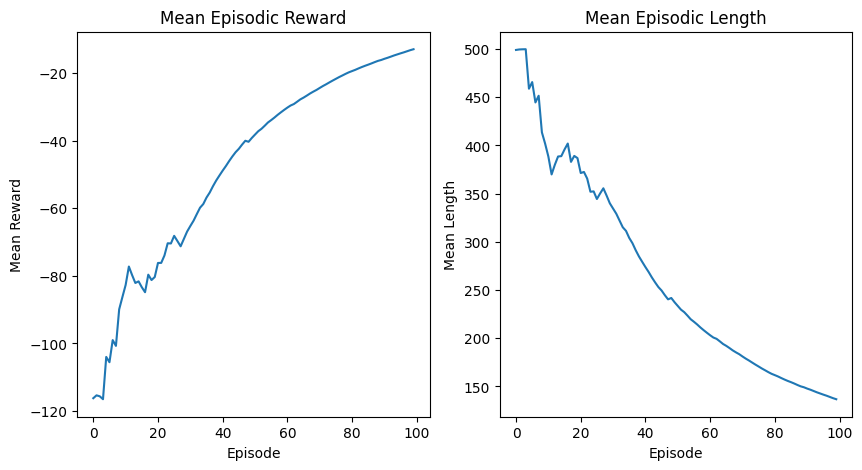

In [18]:
plot_model_performance(mean_rewards, mean_lengths)